In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

# Data

In [57]:
def generate_line(n, sign = "+"):
    t = torch.linspace(-3, 3, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_line_small(n, sign = "+"):
    t = torch.linspace(-1, 1, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_parabola(n, sign = "+"):
    t = torch.linspace(-10, 10, n)
    x = (t).view(-1, 1)
    if sign == "+":
        y =((t**2).view(-1, 1) + 5)/5
    else:
        y = (-(t**2).view(-1, 1) - 5)/5
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_circle(n, r = 1):
    t = torch.linspace(0, 2 * torch.pi - 1e-3, n)
    x = (r * torch.cos(t)).view(-1, 1)
    y = (r * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_sphere(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = (a * torch.sin(grid_t1) * torch.cos(grid_t2)).view(-1, 1)
    y = (b * torch.sin(grid_t1) *  torch.sin(grid_t2)).view(-1, 1)
    z = (c * torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_donut(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = ((torch.sin(grid_t1) + 2) * torch.cos(grid_t2)).view(-1, 1)
    y = ((torch.sin(grid_t1) + 2) *  torch.sin(grid_t2)).view(-1, 1)
    z = 0.5*(torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_3D_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2 * torch.pi, n+1)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-1]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-1]
    z = (0 * torch.sin(t)).view(-1, 1)[:-1]
    return torch.cat((x, y, z), dim=1).unsqueeze(0)


def generate_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2*torch.pi, n+10)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-10]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-10]
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_data(n, sign = "+"):
    line = generate_line(n, sign)
    line2 = generate_line_small(n, sign = '-')
    parabola = generate_parabola(n, sign)
    parabola1 = generate_parabola(n, sign = '-')
    circle = generate_circle(n)
    circle1 = generate_circle(n, r=2)
    el = generate_ellipse(n, r1 = 0.5, r2 = 1)
    e2 = generate_ellipse(n, r1 = 1, r2 = 0.5)
    return torch.concat((el, e2), dim=0)

def plot_data(data, mode = '3D'):
    data = data.to("cpu").detach().numpy()
    
    if mode == '3D':
        fig = plt.figure(figsize=(15, 5))  # Create a wide figure to accommodate three subplots
        
        # First subplot
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.view_init(elev=20, azim=30)  # Set the viewing angle
        for i in range(data.shape[0]):
            ax1.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax1.set_title('View 1')

        # Second subplot
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.view_init(elev=40, azim=60)  # Change the viewing angle
        for i in range(data.shape[0]):
            ax2.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax2.set_title('View 2')

        # Third subplot
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.view_init(elev=60, azim=90)  # Change the viewing angle again
        for i in range(data.shape[0]):
            ax3.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax3.set_title('View 3')

        plt.tight_layout()
        plt.show()
    else:
        for i in range(data.shape[0]):
            plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
        plt.show()

# fIMLE Helpers

In [58]:
class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.fc(x)
    

def generate_NN_latent_functions(num_samples, xdim=1, zdim=2, bias=0):
    class NN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 100)
            self.fc2 = nn.Linear(100, 50)
            self.fc3 = nn.Linear(50, 50)
            self.fc4 = nn.Linear(50, output_dim)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)*5
            return x

    #  weight initialization function
    def weights_init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain = 0.5)
            if m.bias is not None:
                nn.init.constant_(m.bias, bias)

    #  neural networks
    networks = []
    for _ in range(num_samples):
        net = NN(xdim, zdim)
        net.apply(weights_init_normal)
        networks.append(net)
    return networks


In [59]:
def matrices_transform_input(x, n, zdim, mean=0.0, std=1.0):
    _, xdim = x.shape
    #n latent functions (30)
    random_matrices = (torch.randn(n, zdim, xdim)*std + mean).to(device) #(30, 4, 2)
    points_t = x.T.to(device) #(100,2) --> (2,100)
    result = torch.matmul(random_matrices, points_t).permute(0, 2, 1) #(30, 4, 100) --> (30, 100, 4)
    # (points.unsqueeze(0).repeat(n, 1, 1).shape) gives [3, 100, 2] to concatenate the points to the n latent vectors
    result = torch.cat([result, x.unsqueeze(0).repeat(n, 1, 1)], dim=-1)
    print(random_matrices.cpu().numpy())
    print()
    print(result.cpu().numpy())
    return result

def find_nns(Y, G):
    #Y: [1, 1024, 3]
    #G: [20, 1024, 3]

    distances = torch.sum(((Y - G) ** 2), dim = 2).mean(dim = 1)
    _, min_idx = torch.min(distances, dim=0)
    return min_idx.item()

def f_loss(Y, G):
    weighted_diffs = (G - Y)**2
    diffs = torch.sum(weighted_diffs, dim=2)
    total_loss = diffs.mean(dim=1).mean(dim=0)
    return total_loss



def pos_encoder(x, L):

    _, n = x.shape

    encoding = []

    for i in range(n):
        for l in range(L):
            encoding.append(torch.sin(2 ** l * torch.pi * x[:, i:i+1]) )
            encoding.append(torch.cos(2 ** l * torch.pi * x[:, i:i+1]) )

    encoded_x = torch.cat(encoding, dim=-1)
    
    return encoded_x

# Example usage
t = torch.randn(1024, 1) * 50  # Example tensor with 10 points in 2D
encoded_t = pos_encoder(t, L=2)
#print(encoded_t)  # Should print torch.Size([10, 8])
print(encoded_t.shape)
# tensor1 = torch.randn(1, 1024, 3)
# tensor2 = torch.randn(20, 1024, 3)
# find_nns(tensor1, tensor2)
# t = torch.linspace(-3, 3, 7).to(device).unsqueeze(1)
# print(t)
# z = matrices_transform_input(t, 5, 4, std=3)

torch.Size([1024, 4])


# fIMLE Training

In [60]:
epochs = 10000
staleness = 15
num_Z_samples = 50
lr = 0.001
num_points = 1600
xdim = 1
zdim = 15
output_dim = 2

In [61]:

if xdim == 1:
    x = torch.linspace(-5, 5, num_points).to(device).unsqueeze(1)
else:
    x1 = torch.linspace(1.0, 2, 40)
    x2 = torch.linspace(1.0, 2, 40)
    grid_x1, grid_x2 = torch.meshgrid((x1, x2), indexing='ij')
    x = torch.stack((grid_x1, grid_x2), dim=-1).reshape(-1, 2).to(device)
    print(x.cpu().numpy())



data = generate_data(num_points).to(device)
if output_dim == 3:
    #points1 = generate_sphere(40, a = 3, b = 1, c = 1).to(device)[:,0:num_points,:]
    #points2 = generate_sphere(40, a = 1, b = 3, c = 1).to(device)[:,0:num_points,:]
    points1 = generate_3D_ellipse(num_points).to(device)
    points2 = generate_3D_ellipse(num_points, r1=0.5, r2=1).to(device)
    data = torch.concat((points1, points2), dim=0).to(device)




# plt.figure(figsize=(10, 10))
# print(f"x shape:", x.shape)
# print(f"data shape:", data.shape)
# # print(data.cpu().numpy())  
# # print(x)
# if output_dim == 3:
#     plot_data(data, mode = '3D')
# else:
#     plot_data(data, mode = '2D')

  0%|          | 0/10000 [00:00<?, ?it/s]

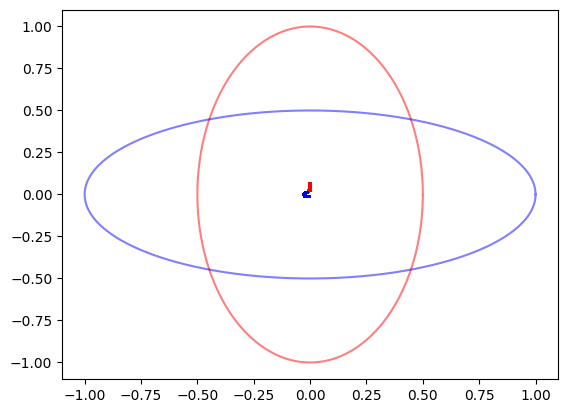

 10%|▉         | 991/10000 [00:09<01:20, 112.00it/s]

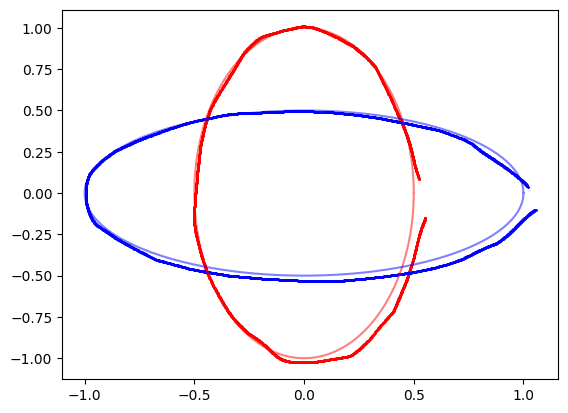

 20%|█▉        | 1996/10000 [00:19<01:13, 108.34it/s]

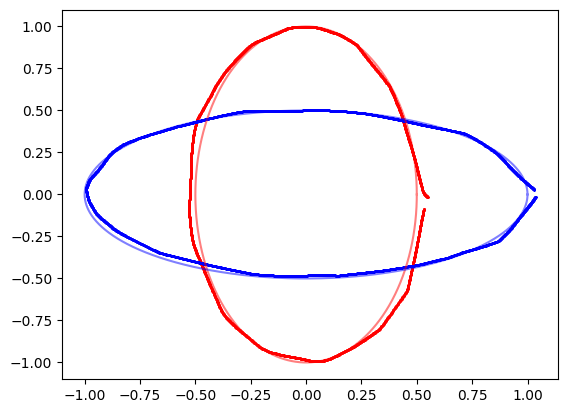

 30%|██▉       | 2986/10000 [00:28<01:07, 104.10it/s]

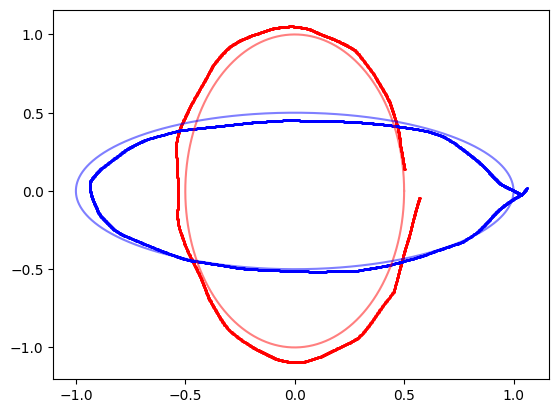

 40%|███▉      | 3991/10000 [00:38<01:11, 84.61it/s] 

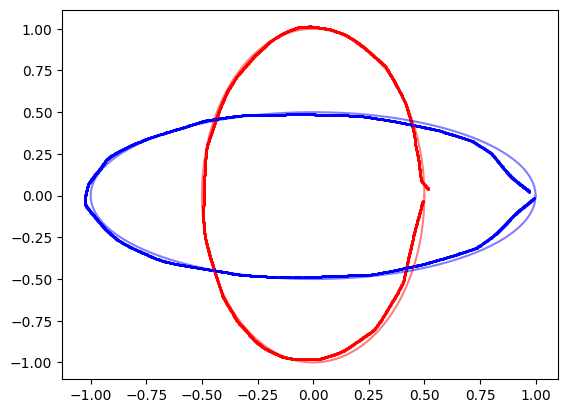

 50%|████▉     | 4996/10000 [00:49<00:55, 89.68it/s] 

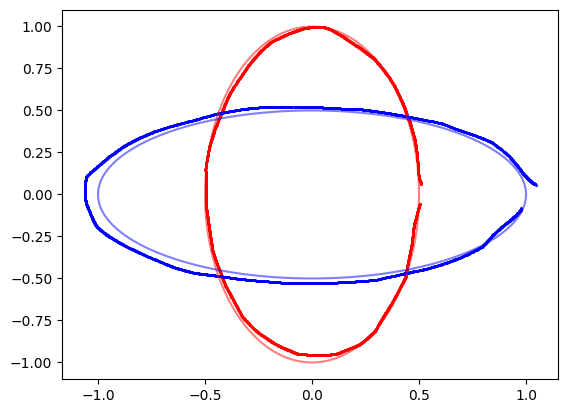

 60%|█████▉    | 5993/10000 [01:05<01:15, 53.21it/s] 

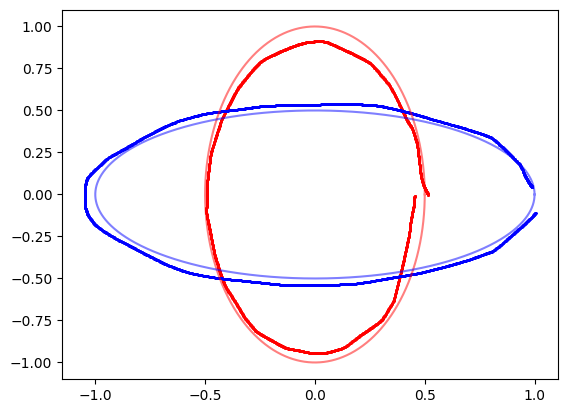

 70%|██████▉   | 6991/10000 [01:21<00:57, 52.00it/s]

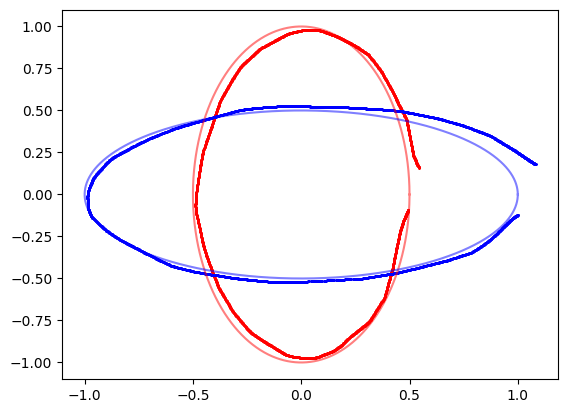

 80%|███████▉  | 7996/10000 [01:39<00:21, 93.43it/s]

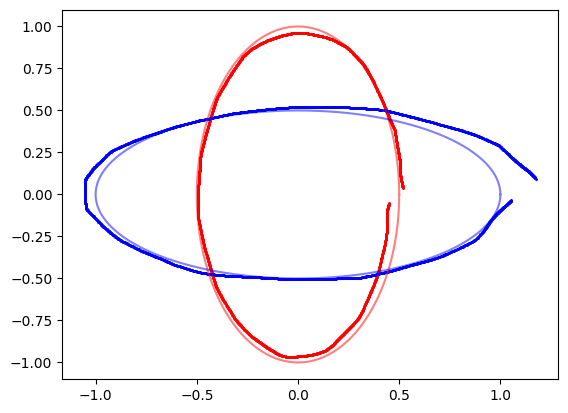

 90%|████████▉ | 8998/10000 [01:56<00:21, 46.14it/s]

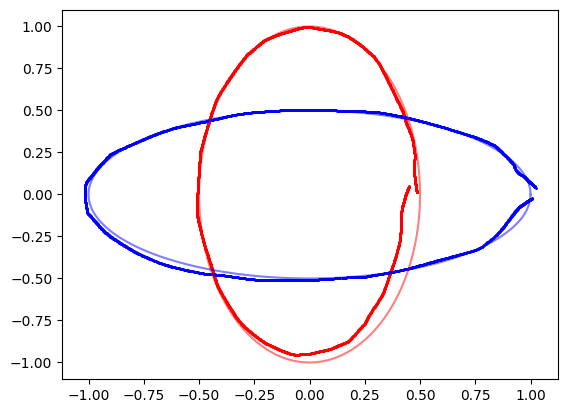

100%|██████████| 10000/10000 [02:16<00:00, 73.31it/s]


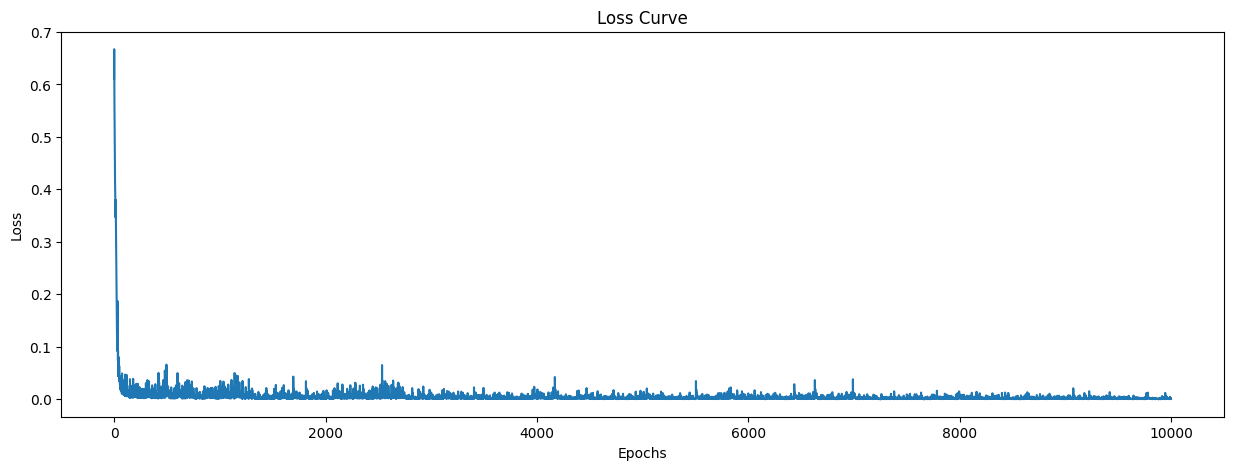

0.0009466680348850787


In [62]:
#_t = H_theta(input_dim=zdim, output_dim=output_dim).to(device)
H_t = H_theta(input_dim=zdim+xdim, output_dim=output_dim).to(device)
optimizer = optim.Adam(H_t.parameters(), lr=lr)
losses = []

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            H_t.eval()
            #zdim = 4
            #xdim = 2
            #num_points = 625
            #num_Z_samples = 40
            Zxs = torch.empty((num_Z_samples, num_points, zdim+xdim)).to(device)
            #contain latent vectors [40, 625, 4+2]
            z_in = pos_encoder(x, L=2)
            Zs = generate_NN_latent_functions(num_samples=num_Z_samples, xdim=4, zdim=zdim, bias=1)
            for i, model in enumerate(Zs):
                model = model.to(device)
                Zxs[i] = torch.cat((model(z_in), x), dim=1).to(device)
                #Zxs[i] = (model(x)*50).to(device)


            # print("Same t:", torch.std(Zxs[:,0,:], dim = 0))
            # print("Different t, same z", torch.std(Zxs[0,:,:], dim = 0))
            #print(Zxs.cpu().numpy())
            #Zxs = matrices_transform_input(x, num_Z_samples, zdim, mean=0.0, std=1.0).to(device)

            #contain latent vectors [40, 625, 3]
            generated = H_t(Zxs) 
            generated = generated.to(device)

            #Get index of best latent vectors for each curve in 'points'
            imle_nns = torch.tensor([find_nns(d, generated) for d in data], dtype=torch.long)    

            #contains best latent vectors [2, 625, 4+2]
            imle_transformed_points = torch.empty((data.shape[0], num_points, zdim+xdim)).to(device)
            imle_transformed_points = Zxs[imle_nns] #Select best latent vectors for each curve (2 curves)

            H_t.train()

    optimizer.zero_grad()
    outs = H_t(imle_transformed_points)
    if e % 1000 == 0:
        outs_disp = outs.to(device='cpu').detach().numpy()
        points_disp = data.to(device='cpu').detach().numpy()
        for i in range(1):
            plt.plot(points_disp[0, :, 0], points_disp[0, :, 1], c='red', alpha=0.5)
            plt.plot(points_disp[1, :, 0], points_disp[1, :, 1], c='blue', alpha=0.5)
            #plt.plot(points_disp[2, :, 0], points_disp[2, :, 1], c='green', alpha=0.5)
            plt.scatter(outs_disp[0, :, 0], outs_disp[0, :, 1], s=1.5, c='red', marker='*')
            plt.scatter(outs_disp[1, :, 0], outs_disp[1, :, 1], s=1.5, c='blue', marker='*')
            #plt.scatter(outs_disp[2, :, 0], outs_disp[2, :, 1], s=1.5, c='green', marker='*')
        plt.show()
    loss = f_loss(data, outs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
print(losses.pop())


In [63]:
# #_t = H_theta(input_dim=zdim, output_dim=output_dim).to(device)
# H_t = H_theta(input_dim=zdim+xdim, output_dim=output_dim).to(device)
# optimizer = optim.Adam(H_t.parameters(), lr=lr)
# losses = []

# for e in tqdm(range(epochs)):
#     with torch.no_grad():
#         if e % staleness == 0:
#             H_t.eval()
#             #zdim = 4
#             #xdim = 2
#             #num_points = 625
#             #num_Z_samples = 40
#             Zxs = torch.empty((num_Z_samples, num_points, zdim+xdim)).to(device)
#             #contain latent vectors [40, 625, 4+2]
#             Zs = generate_NN_latent_functions(num_samples=num_Z_samples, xdim=xdim,zdim=zdim, bias=0)
#             for i, model in enumerate(Zs):
#                 model = model.to(device)
#                 Zxs[i] = torch.cat((model(x), x), dim=1).to(device)
#                 #Zxs[i] = (model(x)*50).to(device)


#             # print("Same t:", torch.std(Zxs[:,0,:], dim = 0))
#             # print("Different t, same z", torch.std(Zxs[0,:,:], dim = 0))
#             #print(Zxs.cpu().numpy())
#             #Zxs = matrices_transform_input(x, num_Z_samples, zdim, mean=0.0, std=1.0).to(device)

#             #contain latent vectors [40, 625, 3]
#             generated = H_t(Zxs) 
#             generated = generated.to(device)

#             #Get index of best latent vectors for each curve in 'points'
#             imle_nns = torch.tensor([find_nns(d, generated) for d in data], dtype=torch.long)    

#             #contains best latent vectors [2, 625, 4+2]
#             imle_transformed_points = torch.empty((data.shape[0], num_points, zdim+xdim)).to(device)
#             imle_transformed_points = Zxs[imle_nns] #Select best latent vectors for each curve (2 curves)

#             H_t.train()

#     optimizer.zero_grad()
#     outs = H_t(imle_transformed_points)
#     if e % 1000 == 0:
#         outs_disp = outs.to(device='cpu').detach().numpy()
#         points_disp = data.to(device='cpu').detach().numpy()
#         for i in range(1):
#             plt.plot(points_disp[0, :, 0], points_disp[0, :, 1], c='red', alpha=0.5)
#             plt.plot(points_disp[1, :, 0], points_disp[1, :, 1], c='blue', alpha=0.5)
#             #plt.plot(points_disp[2, :, 0], points_disp[2, :, 1], c='green', alpha=0.5)
#             plt.scatter(outs_disp[0, :, 0], outs_disp[0, :, 1], s=1.5, c='red', marker='*')
#             plt.scatter(outs_disp[1, :, 0], outs_disp[1, :, 1], s=1.5, c='blue', marker='*')
#             #plt.scatter(outs_disp[2, :, 0], outs_disp[2, :, 1], s=1.5, c='green', marker='*')
#         plt.show()
#     loss = f_loss(data, outs)
#     losses.append(loss.item())
#     loss.backward()
#     optimizer.step()

# plt.figure(figsize=(15, 5))
# plt.plot(losses)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Curve')
# plt.show()
# print(losses.pop())


In [64]:
data = data.to("cpu").detach().numpy()


(50, 1600, 2)


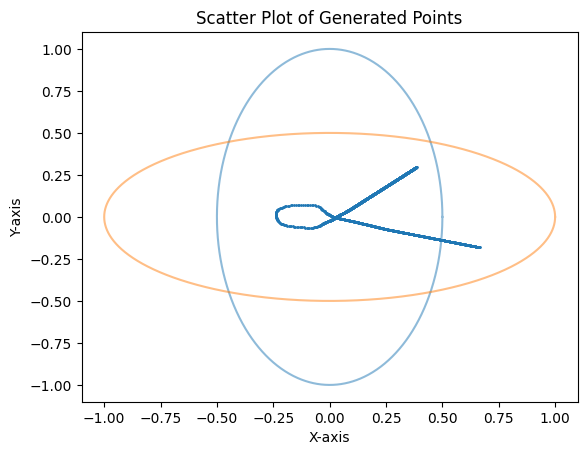

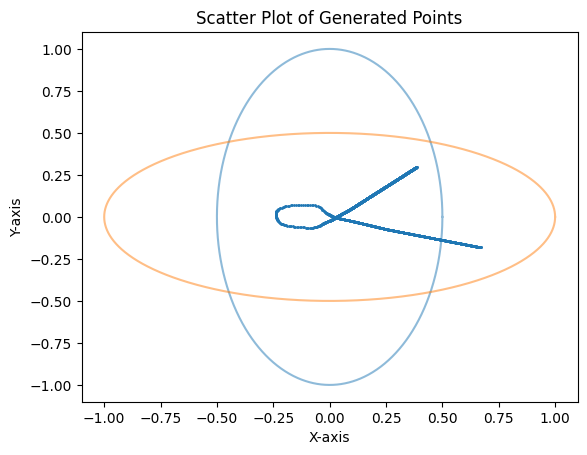

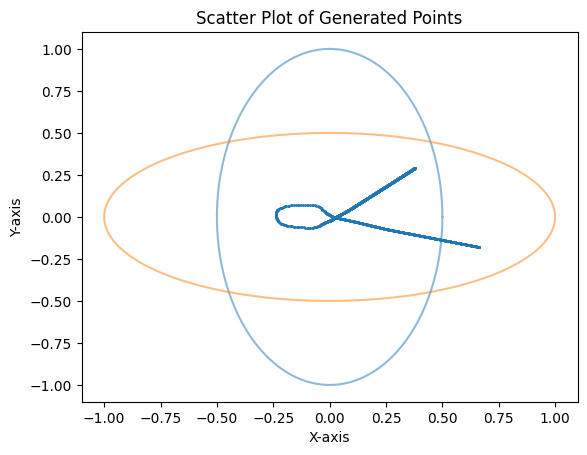

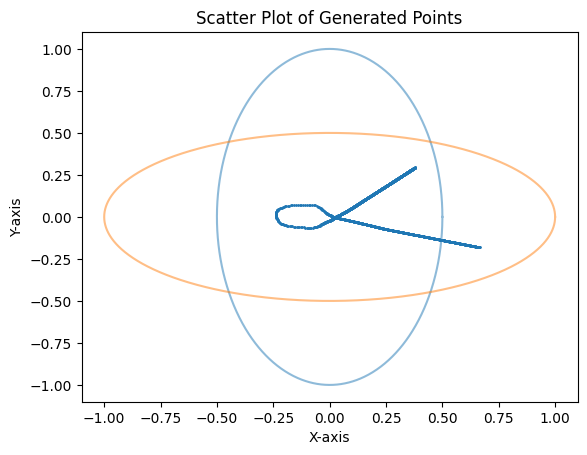

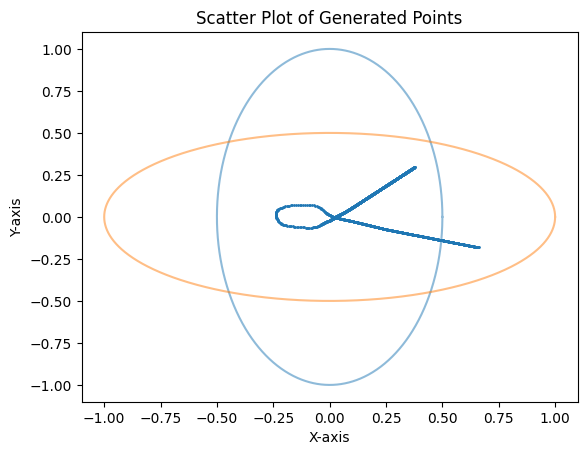

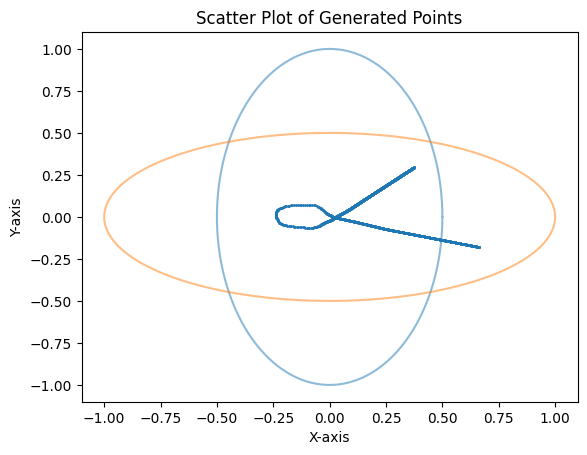

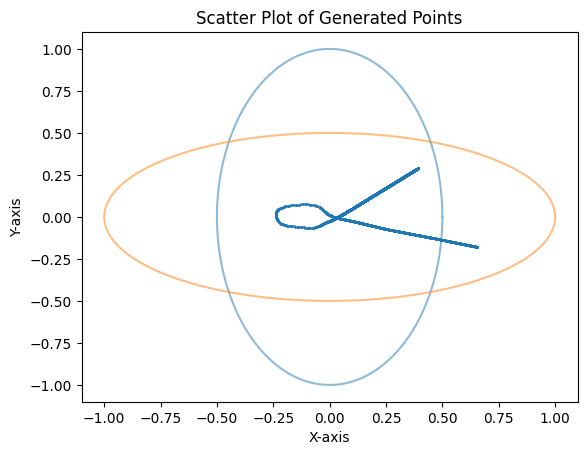

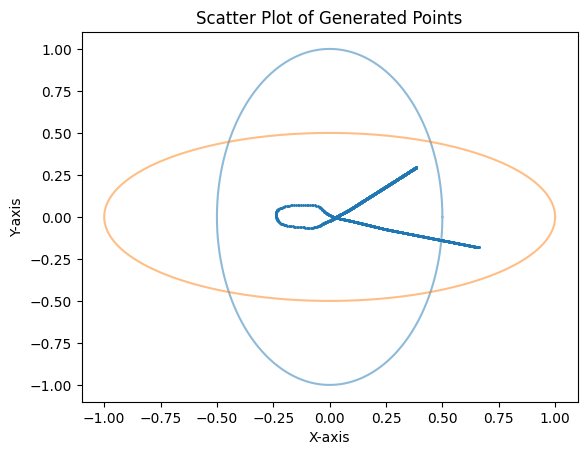

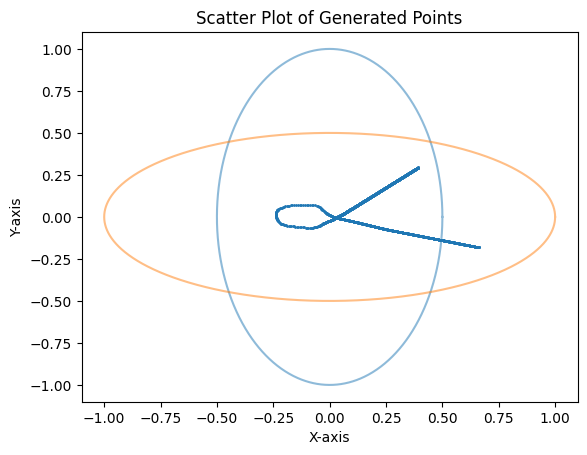

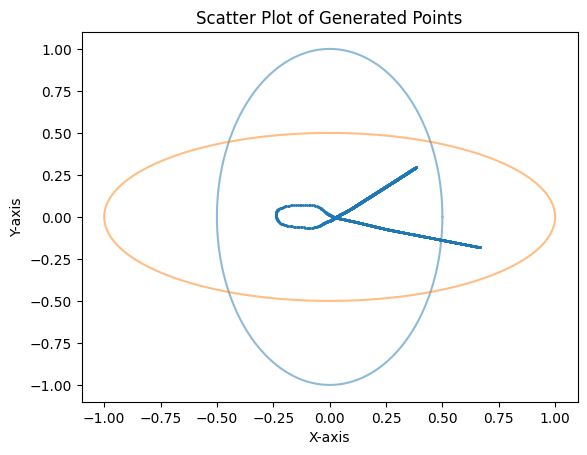

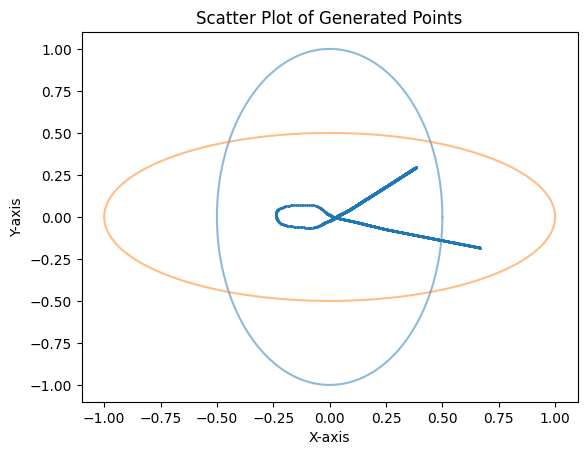

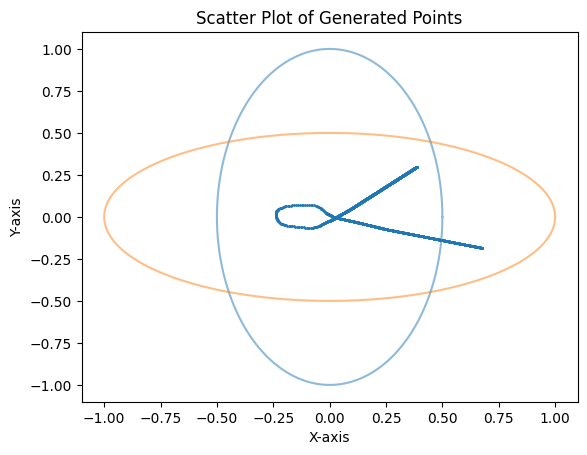

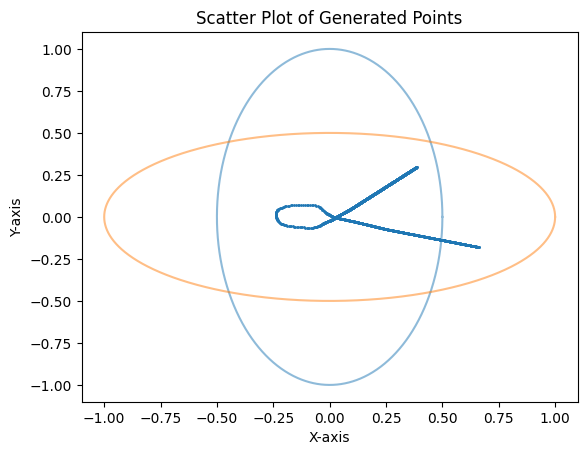

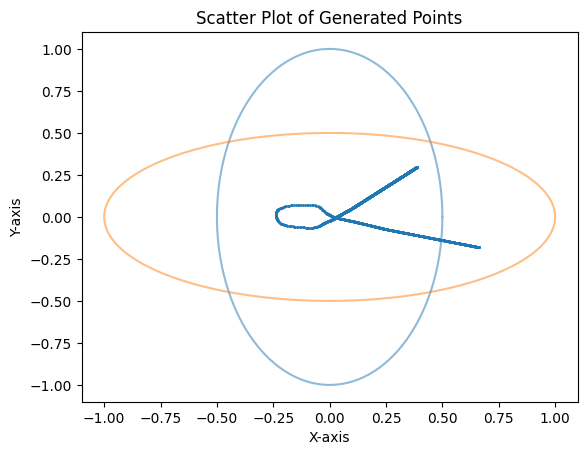

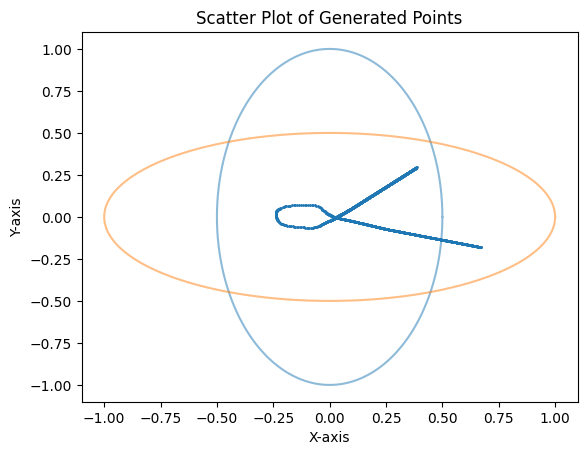

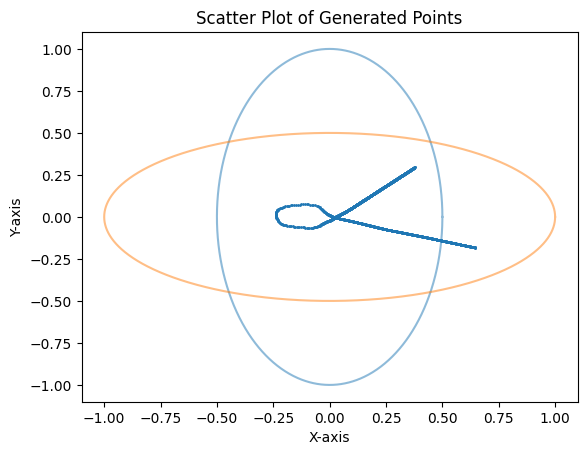

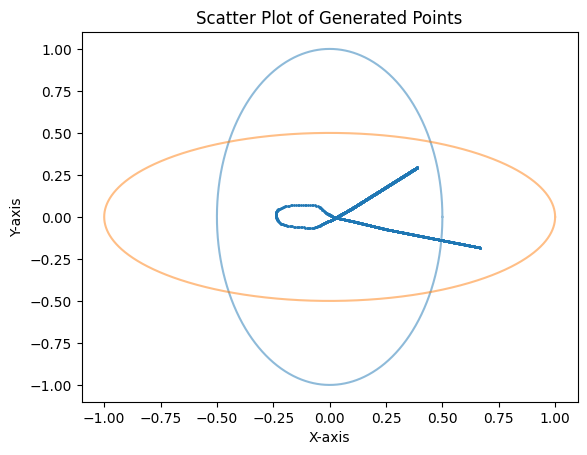

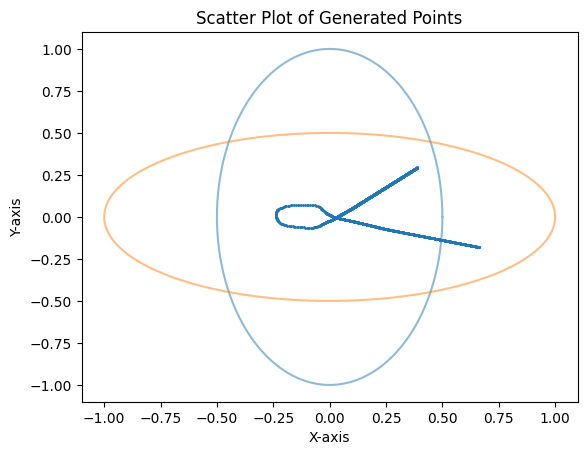

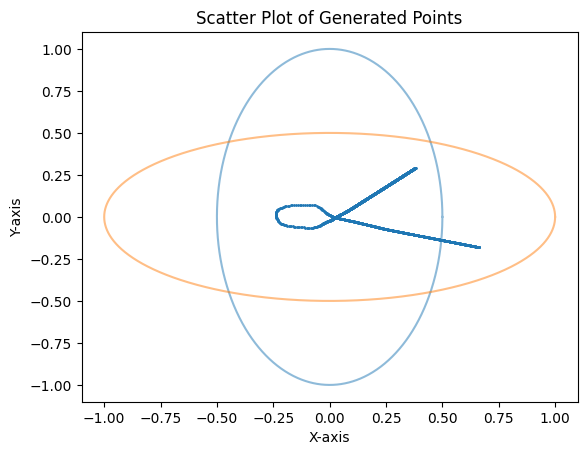

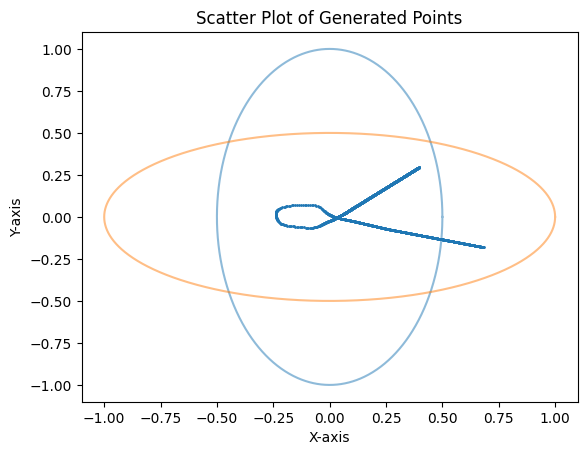

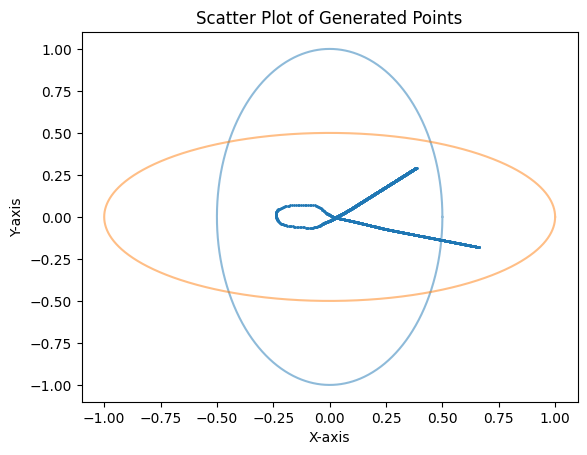

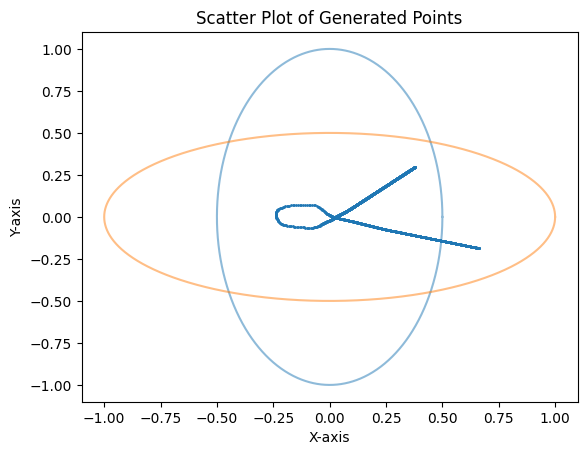

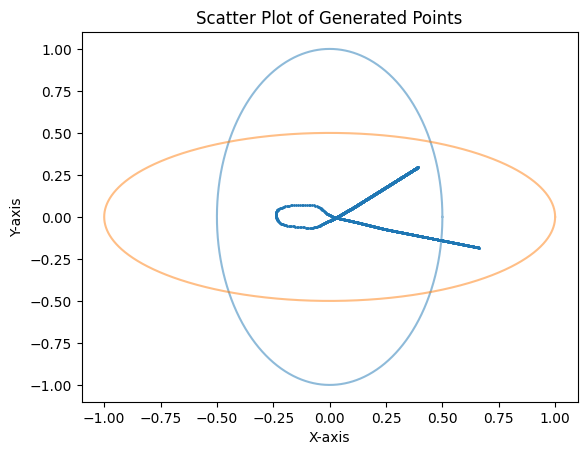

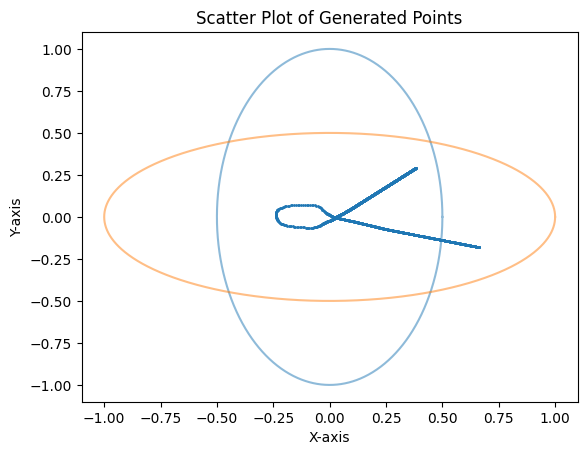

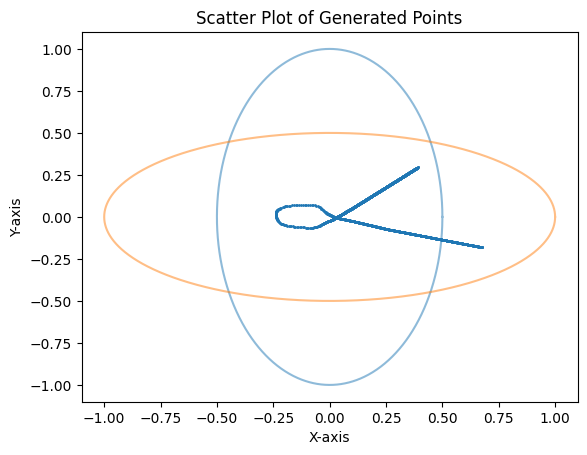

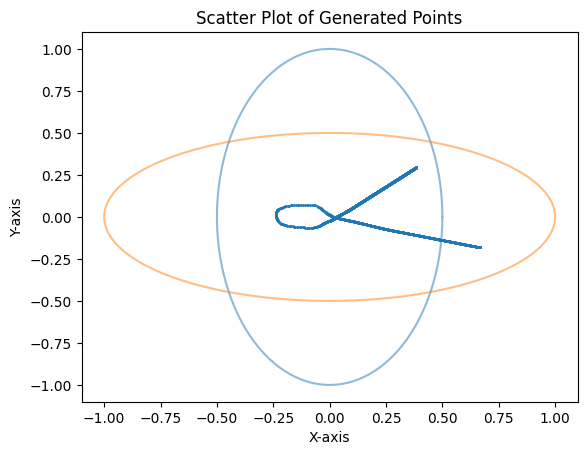

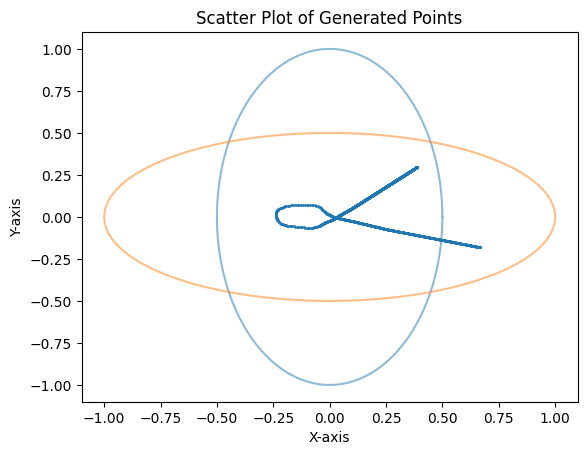

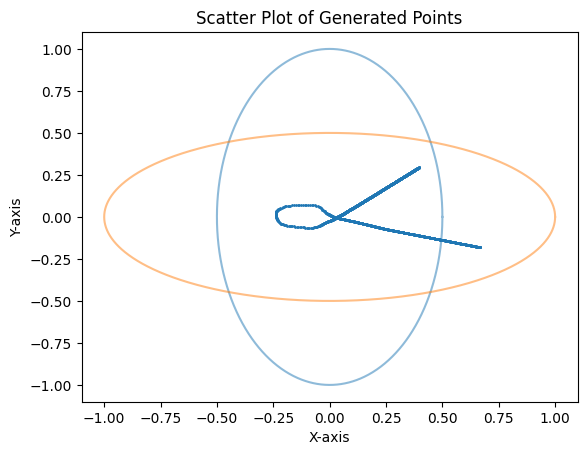

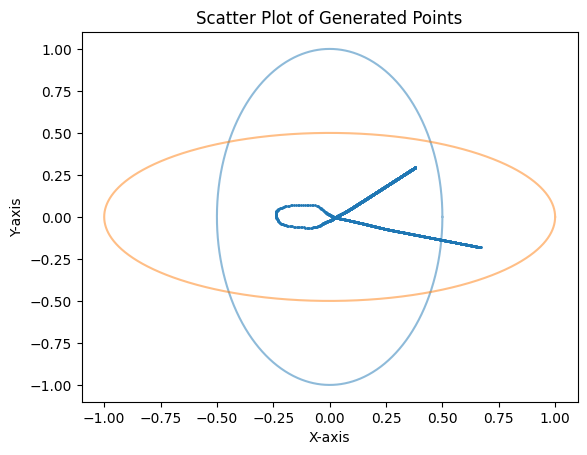

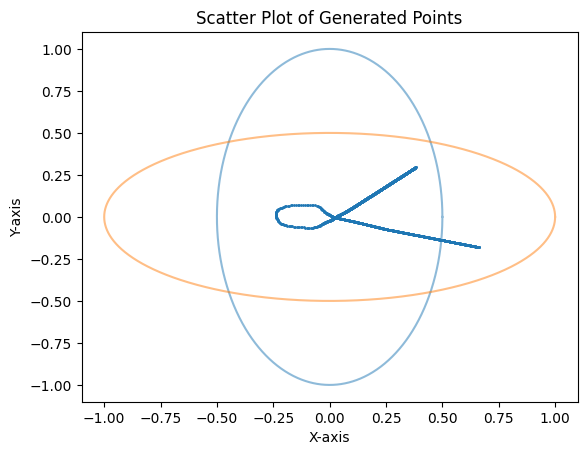

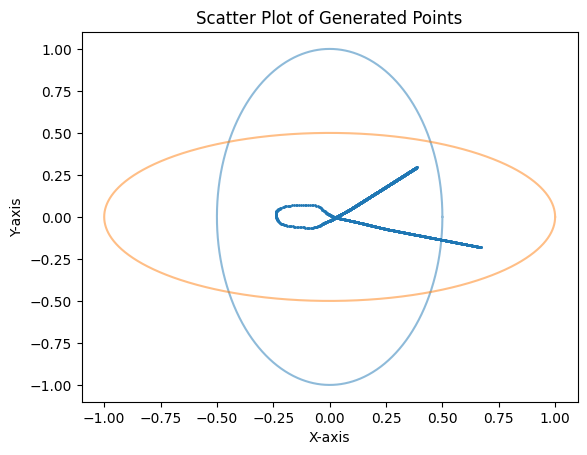

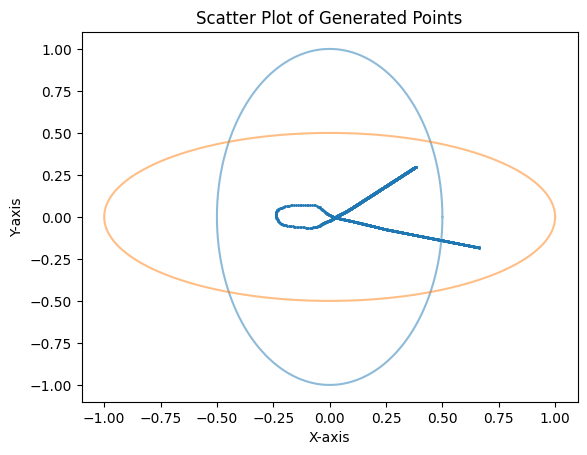

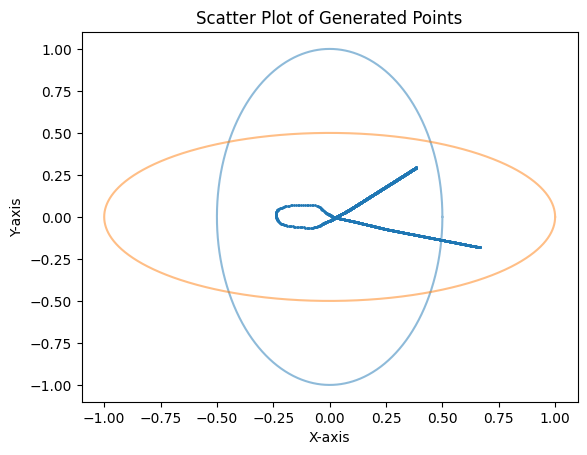

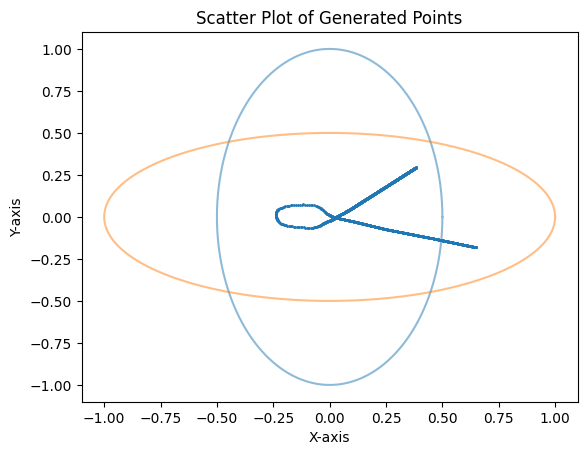

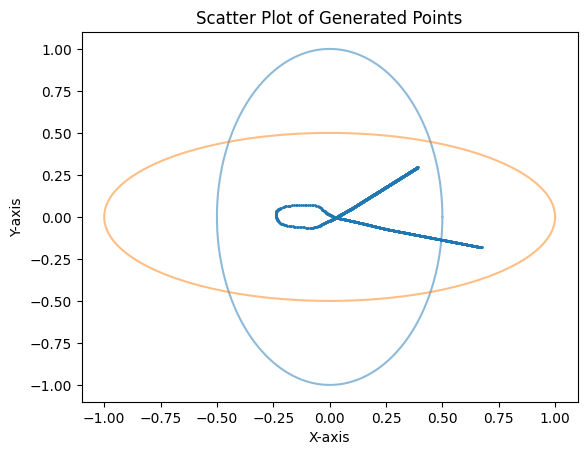

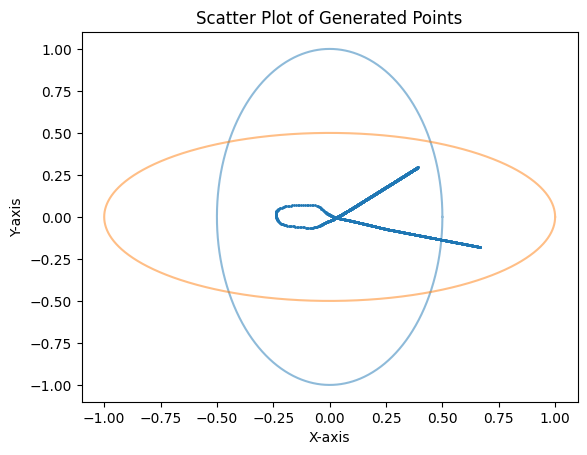

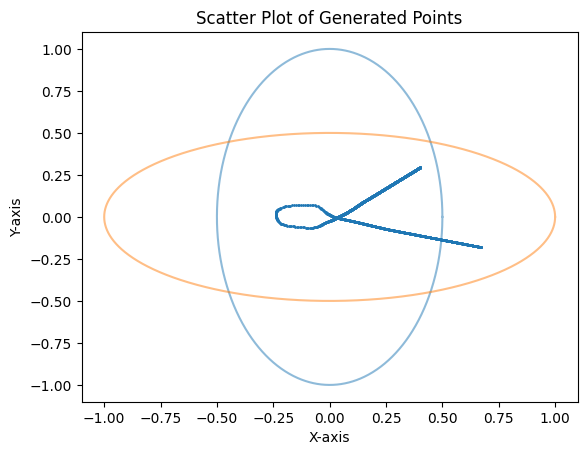

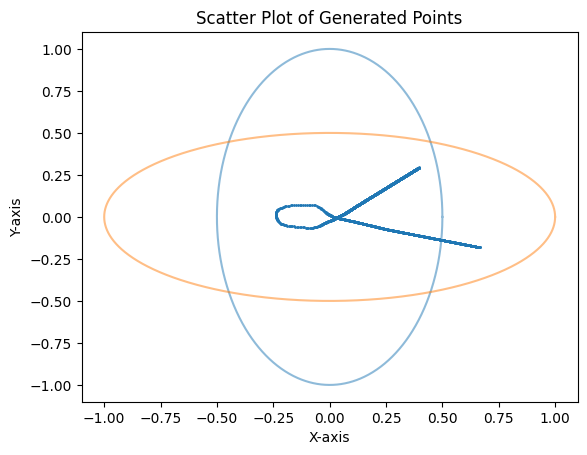

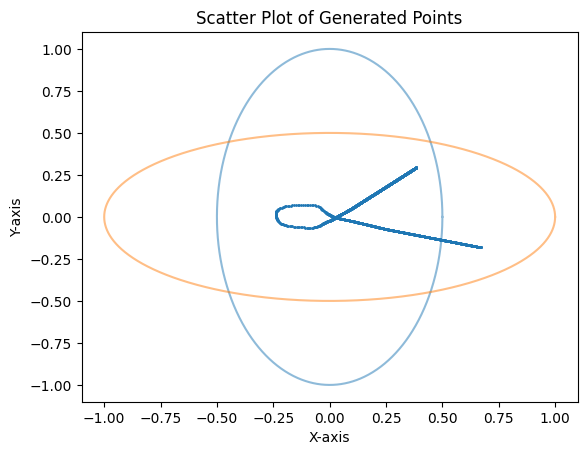

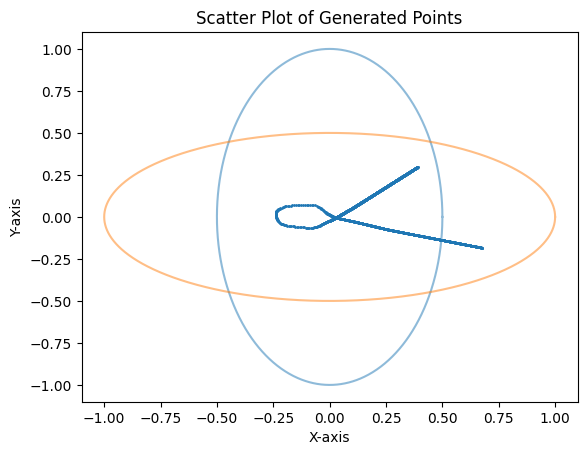

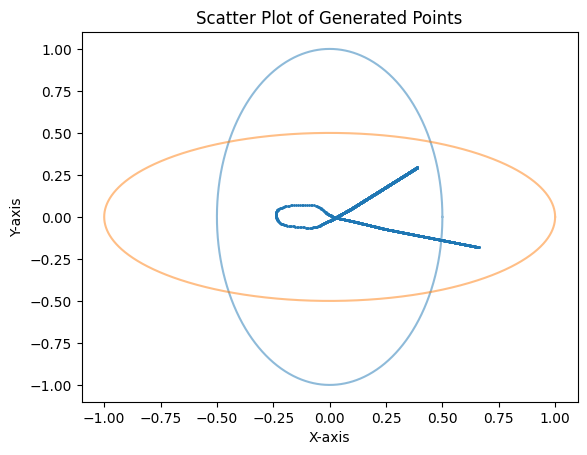

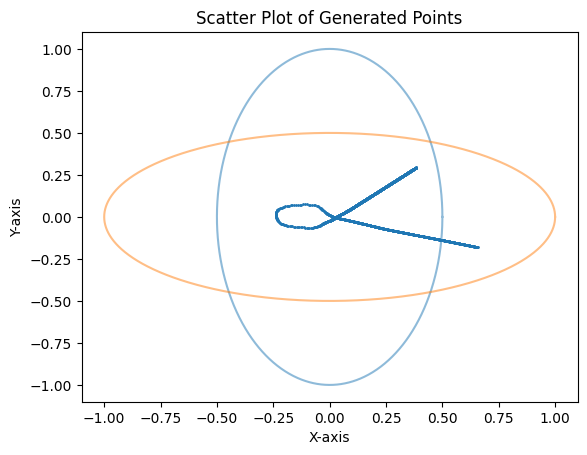

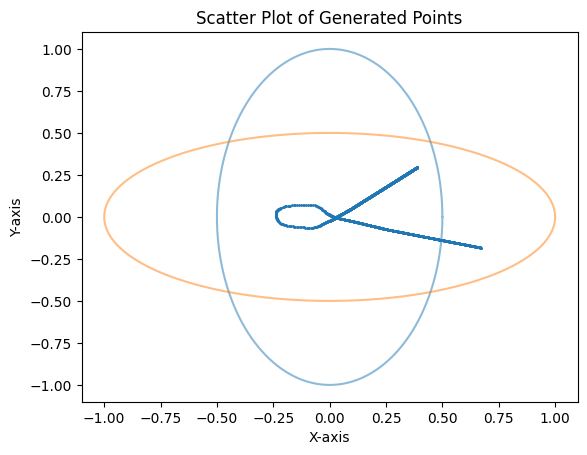

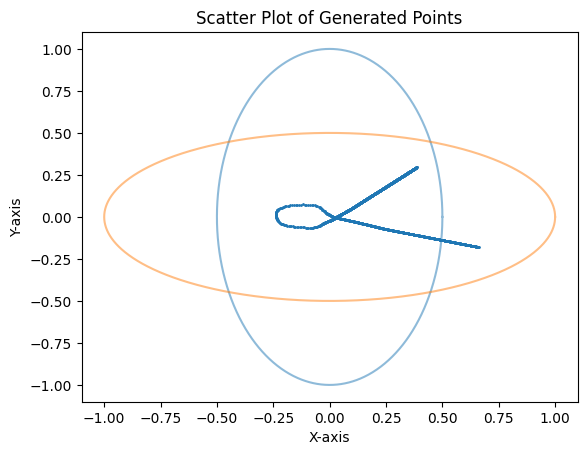

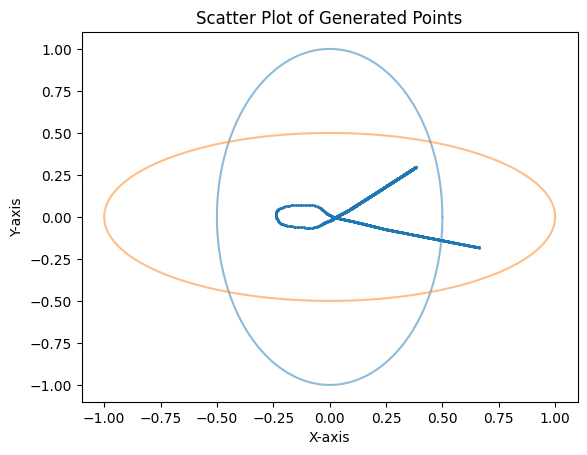

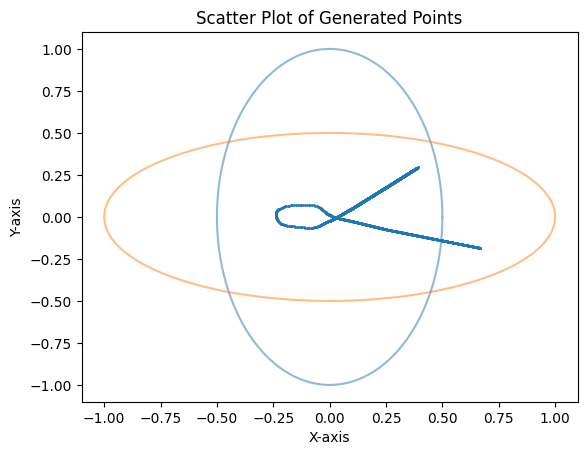

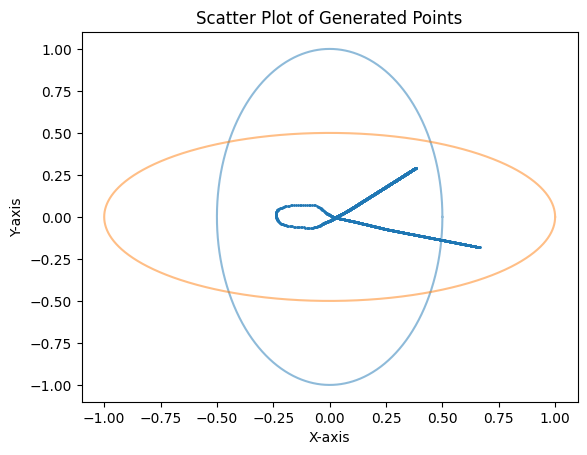

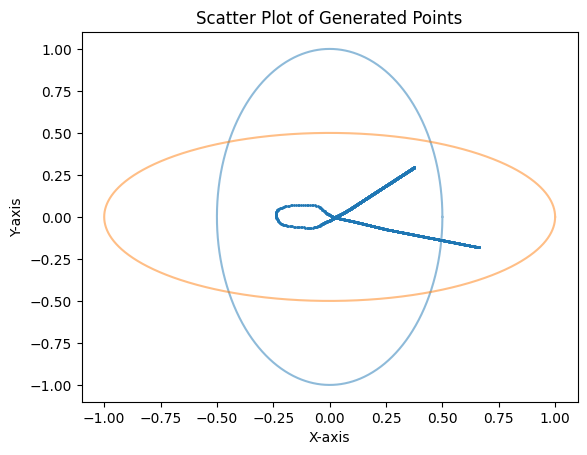

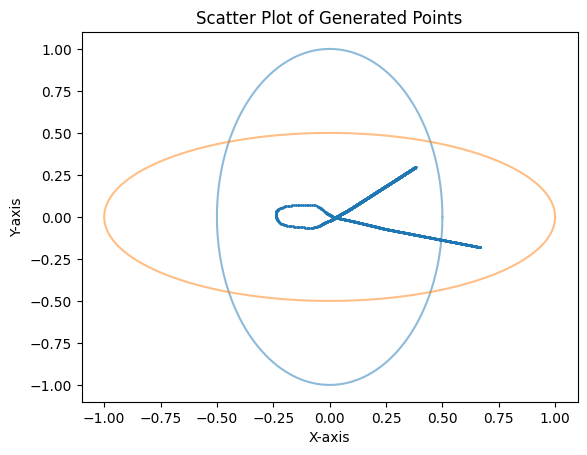

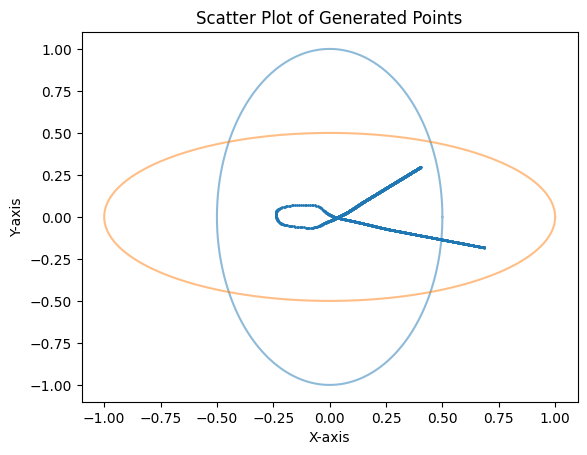

In [65]:
Zxs = torch.empty((50, num_points, zdim+xdim)).to(device)


if output_dim == 2:
    #Zxs = matrices_transform_input(x, 50, zdim, mean=0.0, std=1.0).to(device)
    Zs = generate_NN_latent_functions(num_samples=50, xdim=xdim,zdim=zdim, bias=0)
    for i, model in enumerate(Zs):
        model = model.to(device)
        Zxs[i] = torch.cat((model(x), x), dim=1).to(device)
        
    generated = H_t(Zxs).to("cpu").detach().numpy()
    print(generated.shape)

    

    for i in range(generated.shape[0]):
        for c in data:
                plt.plot(c[:, 0], c[:, 1], alpha=0.5) 
        plt.scatter(generated[i, :, 0], generated[i, :, 1], alpha=1, s= 1)

        plt.title("Scatter Plot of Generated Points")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.show()

In [66]:
if output_dim == 3:
    #data = data.to('cpu').detach().numpy()
    samples_n = 50
    outputs = torch.empty((samples_n, num_points, 2))

    # Assuming a grid with n columns
    n_columns = 10
    n_rows = (samples_n + n_columns - 1) // n_columns  # Calculate the number of rows needed

    #for i in range(samples_n):
    #Zxs = matrices_transform_input(x, samples_n, zdim, mean=0.0, std=0.5).to(device)
    Zs = generate_NN_latent_functions(num_samples=samples_n, xdim=xdim,zdim=zdim)
    for i, model in enumerate(Zs):
        model = model.to(device)
        Zxs[i] = torch.cat((model(x), x), dim=1).to(device)
    out = H_t(Zxs)
    outputs = out.to('cpu')

    print("Output shape", outputs.shape)

    def save_obj_file(vertices, file_path, translation):
        with open(file_path, 'w') as file:
            file.write("# Wavefront OBJ file\n")
            for vertex in vertices:
                translated_vertex = vertex + torch.tensor(translation)
                file.write(f"v {translated_vertex[0]} {translated_vertex[1]} {translated_vertex[2]}\n")

    def tensor_to_obj_files(tensor, base_file_path, n_columns):
        num_objects = tensor.shape[0]
        for i in range(num_objects):
            vertices = tensor[i]
            # Calculate the row and column for the current index
            row = i // n_columns
            col = i % n_columns
            # Translation based on row and column to arrange in a grid
            translation = (col * 7, row * 7, 0)  # Adjust spacing as needed (10 units here)
            file_path = f"{base_file_path}_{i+1}.obj"
            save_obj_file(vertices, file_path, translation)

    # Define the base file path (without extension and index)
    base_file_path = 'C:/Users/rajsh/Desktop/Human_Pose_Generation/ProvNERF Pose Generation/3D_intermediate/vertex_object'

    # Convert tensor to .obj files with rectangular grid separation
    tensor_to_obj_files(outputs, base_file_path, n_columns)
